In [2]:
from fastMONAI.vision_all import *

from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split
import pandas as pd

C:\Users\Eirik\anaconda3\envs\raskmonai\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [3]:
path = Path('..\data')
path.mkdir(exist_ok=True)

In [4]:
BrainTumorSet = DecathlonDataset(root_dir=path, task="Task01_BrainTumour", section="training", download=False,
                                 cache_num=0, num_workers=3)

In [5]:
df = pd.DataFrame(BrainTumorSet.data)


In [6]:
df.head()

,image,label
0,..\data\Task01_BrainTumour\imagesTr\BRATS_442.nii.gz,..\data\Task01_BrainTumour\labelsTr\BRATS_442.nii.gz
1,..\data\Task01_BrainTumour\imagesTr\BRATS_389.nii.gz,..\data\Task01_BrainTumour\labelsTr\BRATS_389.nii.gz
2,..\data\Task01_BrainTumour\imagesTr\BRATS_380.nii.gz,..\data\Task01_BrainTumour\labelsTr\BRATS_380.nii.gz
3,..\data\Task01_BrainTumour\imagesTr\BRATS_245.nii.gz,..\data\Task01_BrainTumour\labelsTr\BRATS_245.nii.gz
4,..\data\Task01_BrainTumour\imagesTr\BRATS_453.nii.gz,..\data\Task01_BrainTumour\labelsTr\BRATS_453.nii.gz


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   388 non-null    object
 1   label   388 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB


In [8]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, test_df.shape

((349, 2), (39, 2))

In [9]:
med_dataset = MedDataset(img_list=train_df.label.tolist()[:20], dtype=MedMask, max_workers=12)

In [10]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1,voxel_count_2,voxel_count_3
0,..\data\Task01_BrainTumour\labelsTr\BRATS_477.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8765377,83088,15826,63709
1,..\data\Task01_BrainTumour\labelsTr\BRATS_350.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8872636,21364,8872,25128
2,..\data\Task01_BrainTumour\labelsTr\BRATS_266.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8725071,83276,69784,49869
3,..\data\Task01_BrainTumour\labelsTr\BRATS_294.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8790699,90806,20231,26264
4,..\data\Task01_BrainTumour\labelsTr\BRATS_466.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8911252,14046,60,2642


In [11]:
summary_df = med_dataset.summary()

In [12]:
summary_df

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,240,240,155,1.0,1.0,1.0,RAS+,..\data\Task01_BrainTumour\labelsTr\BRATS_009.nii.gz,20


In [13]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.0, 1.0, 1.0], False)

In [14]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[240.0, 240.0, 155.0]

In [15]:
item_tfms = [ZNormalization(), PadOrCrop([240,240,160]), RandomAffine(scales=0, degrees=5, isotropic=True)] 

In [16]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(seed=42),
                      get_x=ColReader('image'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms,
                      batch_tfms=None,
                      reorder=reorder,
                      resample=resample)

In [17]:
bs=2
dls = dblock.dataloaders(train_df, bs=bs)

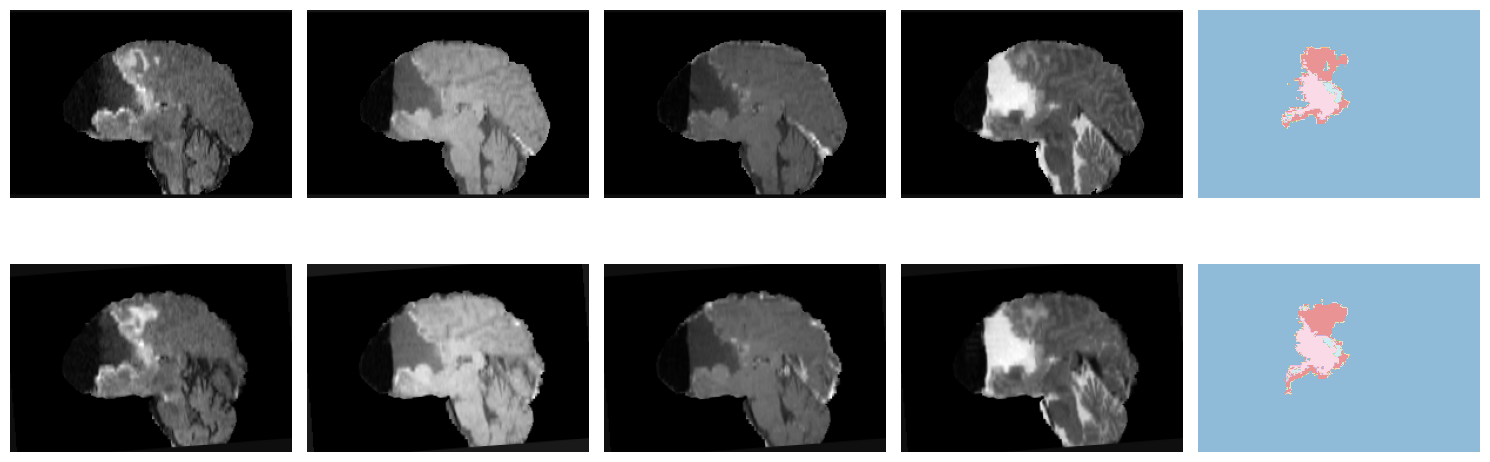

In [18]:
dls.show_batch(anatomical_plane=0, unique=True)

In [19]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(280, 69)

In [20]:
from monai.networks.nets import UNet
from monai.losses import DiceCELoss

In [21]:
codes = np.unique(med_img_reader(train_df.label.tolist()[0]))
n_classes = len(codes)

In [22]:
codes, n_classes

(array([0., 1., 2., 3.], dtype=float32), 4)

In [23]:
model = UNet(dimensions=3, in_channels=4, out_channels=n_classes, 
             channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), 
             num_res_units=2)

C:\Users\Eirik\anaconda3\envs\raskmonai\lib\site-packages\monai\utils\deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)


In [24]:
loss_func = CustomLoss(loss_func=DiceCELoss(to_onehot_y=True, include_background=True, softmax=True))

In [25]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=multi_dice_score)

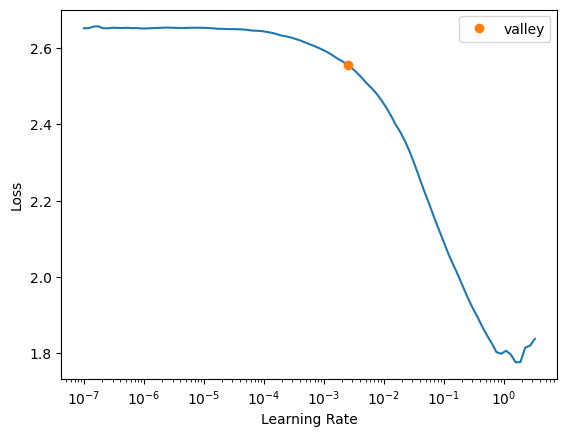

In [26]:
lr = learn.lr_find()#.to_fp16()

In [27]:
epochs = 4

In [28]:
learn.fit_flat_cos(epochs, lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,1.031468,0.733202,"tensor([0.3851, 0.0101, 0.2169])",08:11
1,0.585890,0.516198,"tensor([0.6118, 0.0010, 0.5205])",08:49
2,0.471542,0.408908,"tensor([0.6374, 0.3980, 0.5996])",08:32
3,0.373850,0.355638,"tensor([0.6890, 0.4428, 0.6532])",08:01


In [29]:
learn.save('baseline.braintumor-model')

Path('models/baseline.braintumor-model.pth')

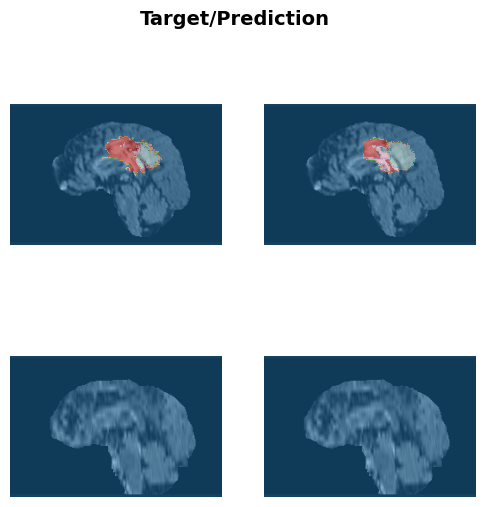

In [30]:
learn.show_results(anatomical_plane=0, ds_idx=1)

In [82]:
test_dl = learn.dls.test_dl(test_df,with_labels=True)

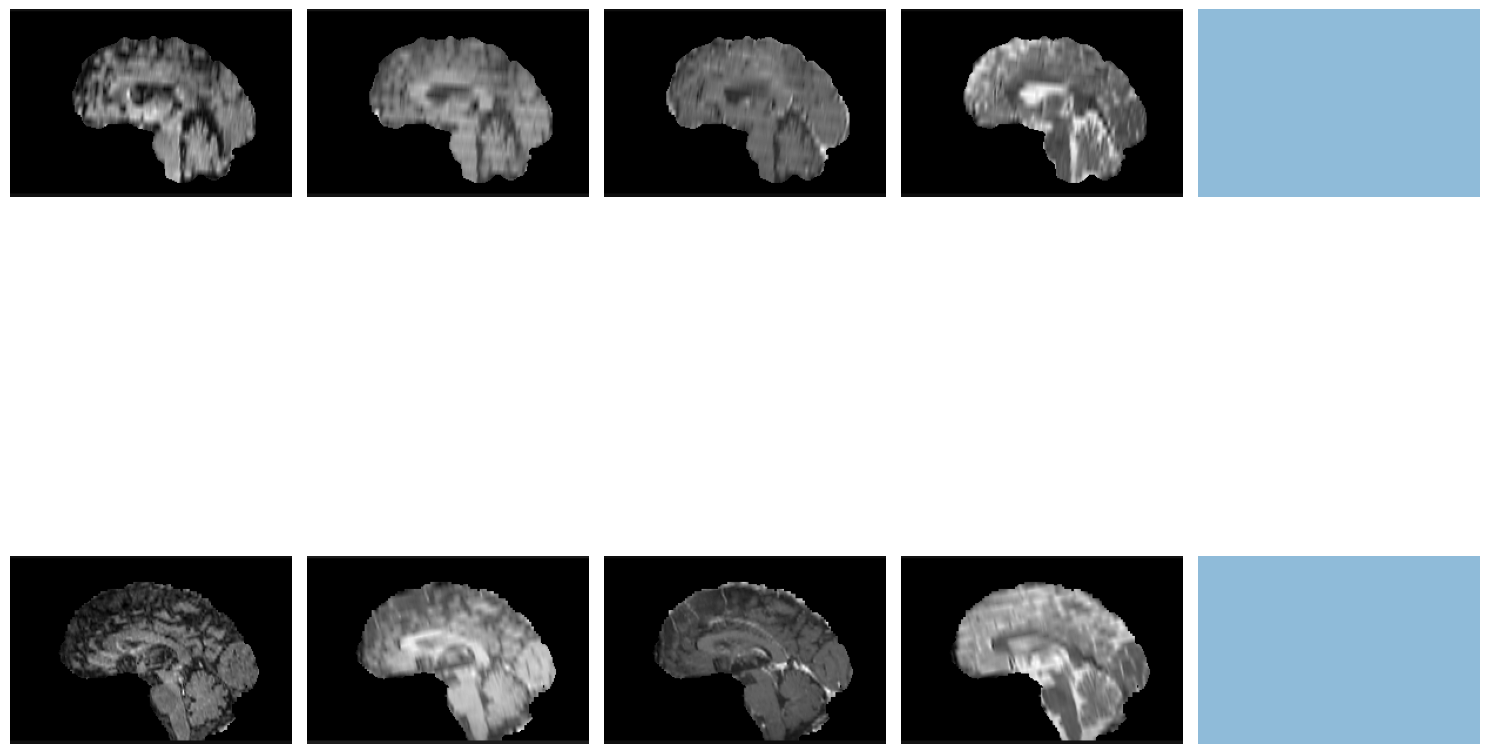

In [83]:
test_dl.show_batch(anatomical_plane=0, figsize=(15,15))

In [84]:
pred_acts, labels = learn.get_preds(dl=test_dl)
pred_acts.shape, labels.shape

(torch.Size([39, 4, 240, 240, 160]), torch.Size([39, 1, 240, 240, 160]))

In [85]:
multi_dice_score(pred_acts, labels)

tensor([0.6513, 0.4564, 0.6934])

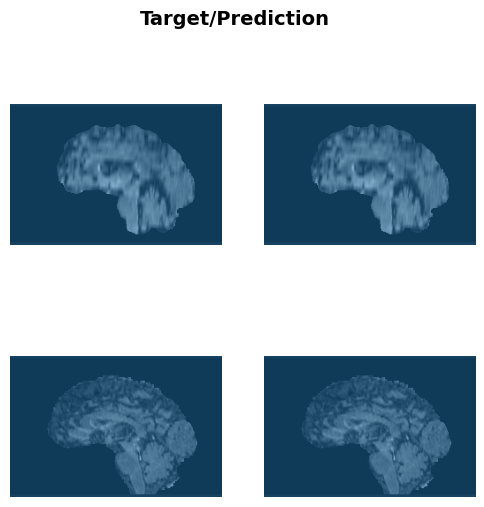

In [86]:
learn.show_results(anatomical_plane=0, dl=test_dl, ds_idx=19)

In [87]:
learn.export('baseline_braintumor_model.pkl')